In [157]:
import bs4 as bs  #  beautifulsoup 4
import urllib
import urllib.request
import json
import pandas as pd
import time

# Module 1: Download TSMC Stock Data and Store in SQL Database
def get_stock_data(year, month, sid): # get a month in once scype
    base_url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={:d}{:02d}01&stockNo={:s}"
    target_url = base_url.format(year,month,sid)
    # get data and parsing (剖析)
    webpage_history = urllib.request.urlopen(target_url)
    web_html = bs.BeautifulSoup(webpage_history, 'html.parser')
    stock = json.loads(web_html.text)  #  讀取 JSON 資料 -> 轉換成 dictionary
    stock_info = list(stock.values())  #  轉換成 list 格式
    stock_price = pd.DataFrame(stock_info[4]) # 使用pandas創建dataframe(資料表格)
    stock_price.columns = stock_info[3] # 將 data frame 資料加上 column name
    return stock_price # 傳回 dataframe

def get_stock_datas(start_year,start_month,stop_year,stop_month,sid): # include stoped month
    year = start_year
    month = start_month
    
    df_list = [] # prepare empty list to store dataframes of each month
    while True:
        # download
        print("[Downloading] year = {:d}, month = {:2d}".format(year, month))
        df = get_stock_data(year,month, sid) # get a month of data
        df_list.append(df) # append into list
        # check if abort
        if (year == stop_year and month == stop_month):
            break
        # if not abort, then increase one month
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
        # delay a little time
        time.sleep(5) # 5 sec 

    
    fused_df = pd.concat(df_list, ignore_index=True, axis=0) # ignore_index (忽略原有的index)
    fused_df["sid"] = sid
    return fused_df # return dataframe

from sqlalchemy import create_engine
def store_to_sql(df,name):
    # create a referrence for sql library 
    engine = create_engine('sqlite://', echo = False) 
    df.to_sql(name, con = engine) 
    return engine


# Module 2: Retrieve Data and Plot K-line and Price-Volume Graphs
from sqlalchemy import text
# visual
import matplotlib
import matplotlib.pyplot as plt
import mpl_finance as mpf
%matplotlib inline
import seaborn as sns
#time
import datetime as datetime

def plot_stock_data(engine, sql_name, sid):
    # Retrieve data from SQL
    conn = engine.connect()
    query = text(f"SELECT * FROM {sql_name} WHERE sid = '{sid}'")
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    df = df.drop(columns="index")
    df.set_index('日期')
    
    df['成交股數'] = df['成交股數'].str.replace(",","")
    df['成交金額'] = df['成交金額'].str.replace(",","")
    df['成交筆數'] = df['成交筆數'].str.replace(",","")

    # Plotting K-line and Price-Volume graphs
    # 繪製 Ｋ線
    fig = plt.figure(figsize=(24, 15))
    ax = fig.add_axes([0,0.2,1,0.5])
    ax2 = fig.add_axes([0,0,1,0.2],sharex = ax)

    ax2.set_xticks(range(0, len(df['日期']), 20))
    ax2.set_xticklabels(df['日期'][::20])
    
    plt.title(f"stock ID {sid}", fontsize=18)
    mpf.candlestick2_ochl(ax,
                          df['開盤價'].astype(float),
                          df['收盤價'].astype(float),
                          df['最高價'].astype(float),
                          df['最低價'].astype(float),
                          width=0.6, colorup='r', colordown='g', alpha=0.75)

    mpf.volume_overlay(ax2, 
                       df['開盤價'].astype(float),
                       df['收盤價'].astype(float),
                       df['成交股數'].astype(float),
                       colorup='r', colordown='g', width=0.5, alpha=0.8)
    
    plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 




# Module 3: Moving Averages and Identifying Golden/Death Cross
def plot_stock_data_with_moving_averages(engine, sql_name, sid, short_window, long_window):
    conn = engine.connect()
    query = f"SELECT * FROM {sql_name} WHERE sid = '{sid}'"
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    df = df.drop(columns="index")
    df.set_index('日期')
    
    df['short_ma'] = df['收盤價'].rolling(window=short_window).mean()
    df['long_ma'] = df['收盤價'].rolling(window=long_window).mean()
    
    # Identifying Golden Cross and Death Cross
    golden_crosses = df[(df['short_ma'] > df['long_ma']) & (df['short_ma'].shift(1) <= df['long_ma'].shift(1))]
    death_crosses = df[(df['short_ma'] < df['long_ma']) & (df['short_ma'].shift(1) >= df['long_ma'].shift(1))]
    
    df['成交股數'] = df['成交股數'].str.replace(",","")
    df['成交金額'] = df['成交金額'].str.replace(",","")
    df['成交筆數'] = df['成交筆數'].str.replace(",","")

    # Plotting K-line and Price-Volume graphs
    # 繪製 Ｋ線
    fig = plt.figure(figsize=(24, 15))
    ax = fig.add_axes([0,0.2,1,0.5])
    ax2 = fig.add_axes([0,0,1,0.2],sharex = ax)

    ax.set_xticks(range(0, len(df['日期']), 20))
    ax.set_xticklabels(df['日期'][::20])
    
    plt.title(f"stock ID {sid}", fontsize=18)
    
    # 繪製 均線
    ax.plot(df['日期'], df['short_ma'].to_numpy(), label=f'{short_window}-Day MA')
    ax.plot(df['日期'], df['long_ma'].to_numpy(), label=f'{long_window}-Day MA')
    ax.scatter(golden_crosses['日期'], golden_crosses['short_ma'], color='gold', label='Golden Cross', marker='^')
    ax.scatter(death_crosses['日期'], death_crosses['short_ma'], color='black', label='Death Cross', marker='v')
    
    mpf.candlestick2_ochl(ax,
                          df['開盤價'].astype(float),
                          df['收盤價'].astype(float),
                          df['最高價'].astype(float),
                          df['最低價'].astype(float),
                          width=0.6, colorup='r', colordown='g', alpha=0.75)
    
    ax2.set_xticks(range(0, len(df['日期']), 20))
    ax2.set_xticklabels(df['日期'][::20])
    
    mpf.volume_overlay(ax2, 
                       df['開盤價'].astype(float),
                       df['收盤價'].astype(float),
                       df['成交股數'].astype(float),
                       colorup='r', colordown='g', width=0.5, alpha=0.8)
    
    plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
    ax.legend()



In [158]:
# step 1
sid = "2330" # stock id
sql_name = "stock_data" # sql db name
df = get_stock_datas(2020,1,2024,4,sid)
engine = store_to_sql(df,sql_name) # get returned engine 

[Downloading] year = 2020, month =  1
[Downloading] year = 2020, month =  2
[Downloading] year = 2020, month =  3
[Downloading] year = 2020, month =  4
[Downloading] year = 2020, month =  5
[Downloading] year = 2020, month =  6
[Downloading] year = 2020, month =  7
[Downloading] year = 2020, month =  8
[Downloading] year = 2020, month =  9
[Downloading] year = 2020, month = 10
[Downloading] year = 2020, month = 11
[Downloading] year = 2020, month = 12
[Downloading] year = 2021, month =  1
[Downloading] year = 2021, month =  2
[Downloading] year = 2021, month =  3
[Downloading] year = 2021, month =  4
[Downloading] year = 2021, month =  5
[Downloading] year = 2021, month =  6
[Downloading] year = 2021, month =  7
[Downloading] year = 2021, month =  8
[Downloading] year = 2021, month =  9
[Downloading] year = 2021, month = 10
[Downloading] year = 2021, month = 11
[Downloading] year = 2021, month = 12
[Downloading] year = 2022, month =  1
[Downloading] year = 2022, month =  2
[Downloading

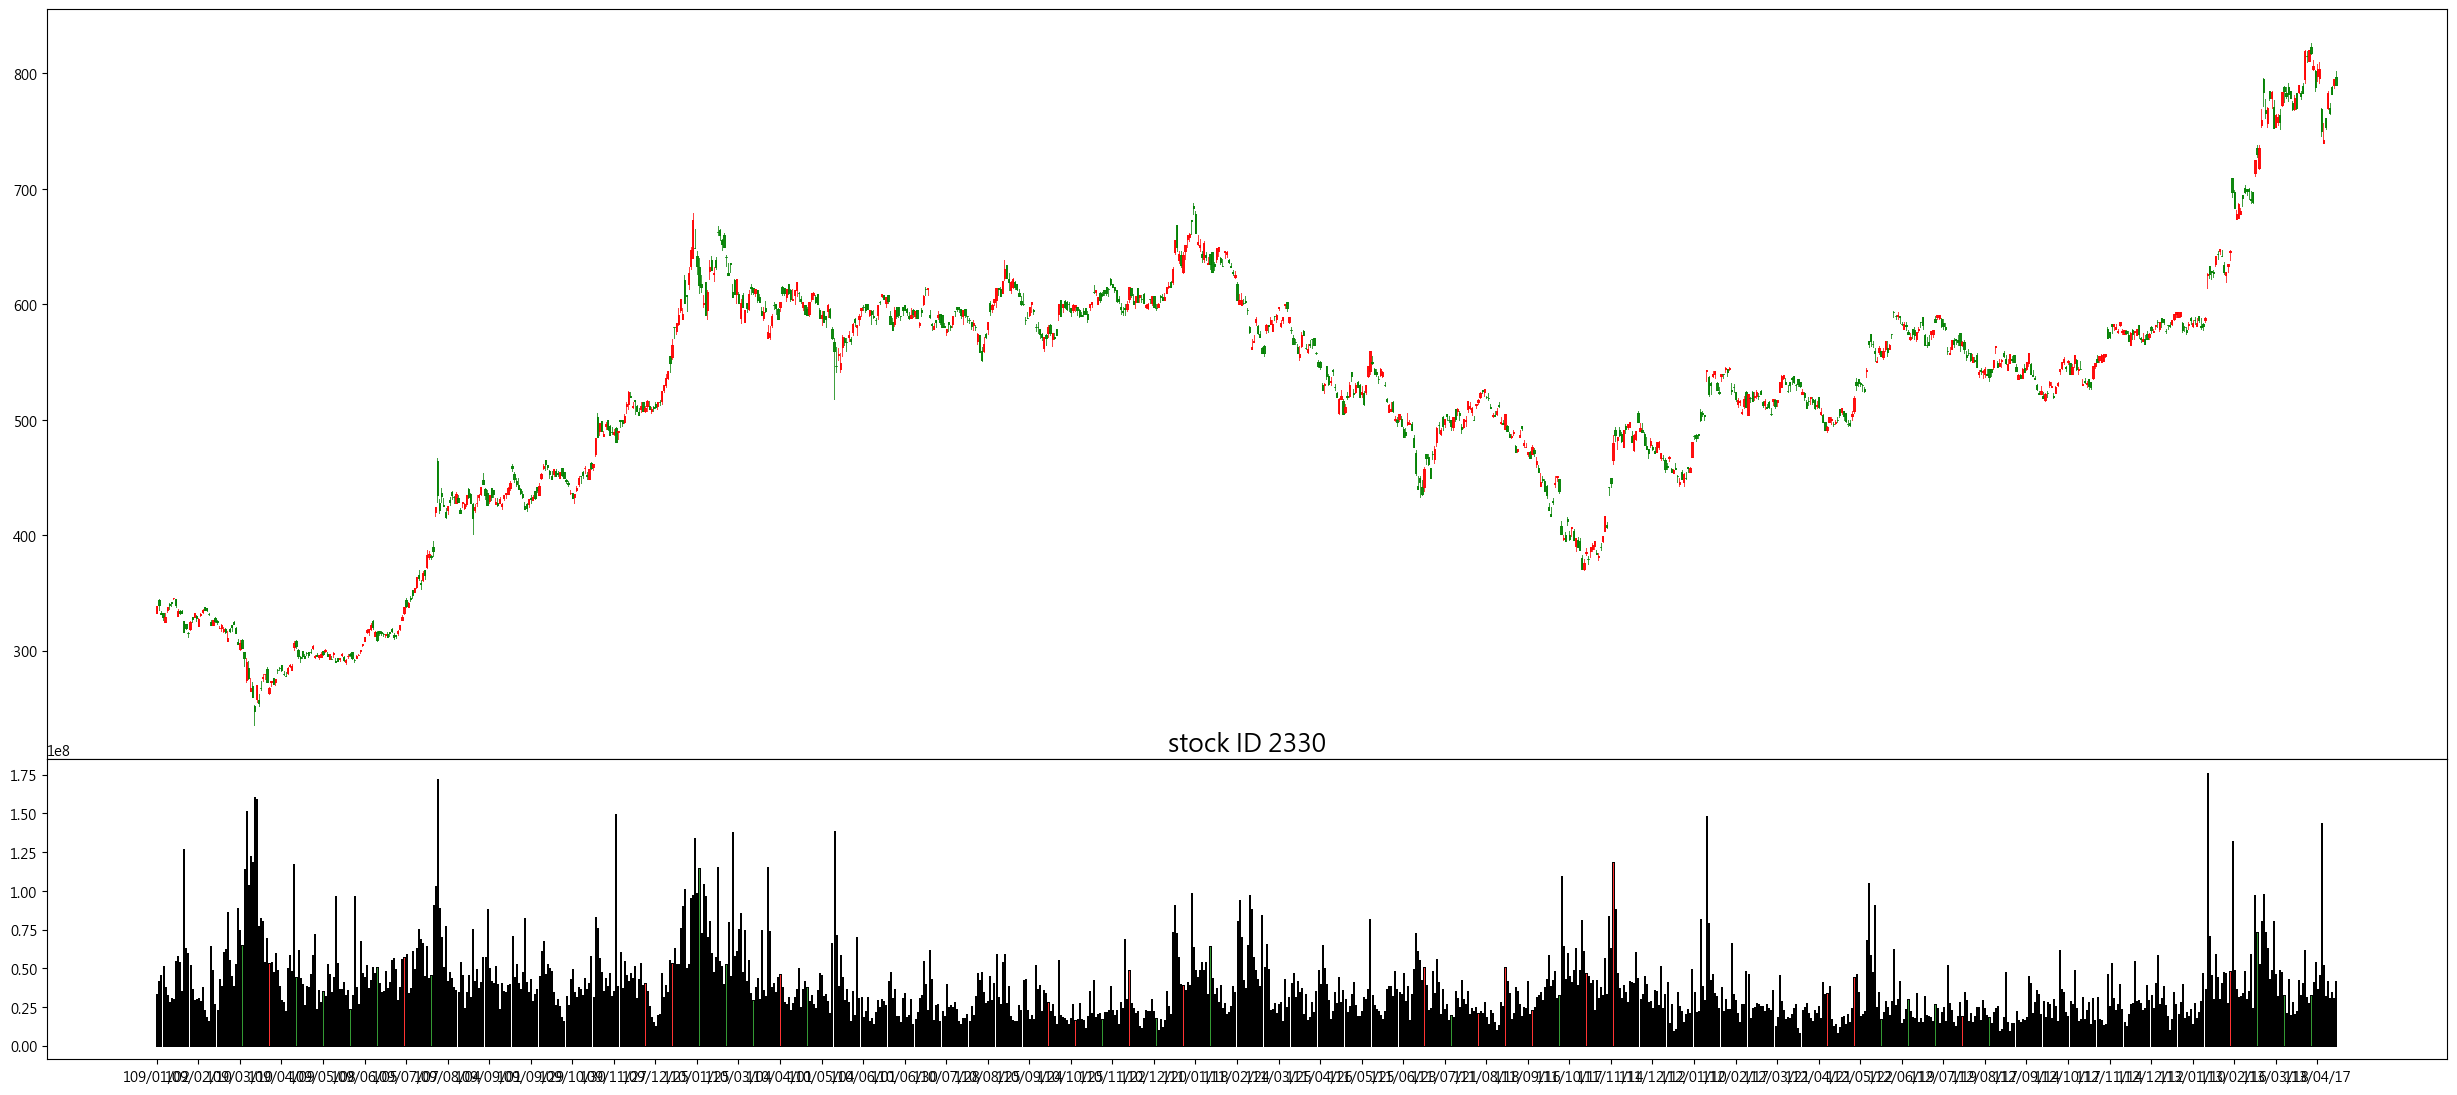

In [159]:
# step 2
plot_stock_data(engine, sql_name, sid)

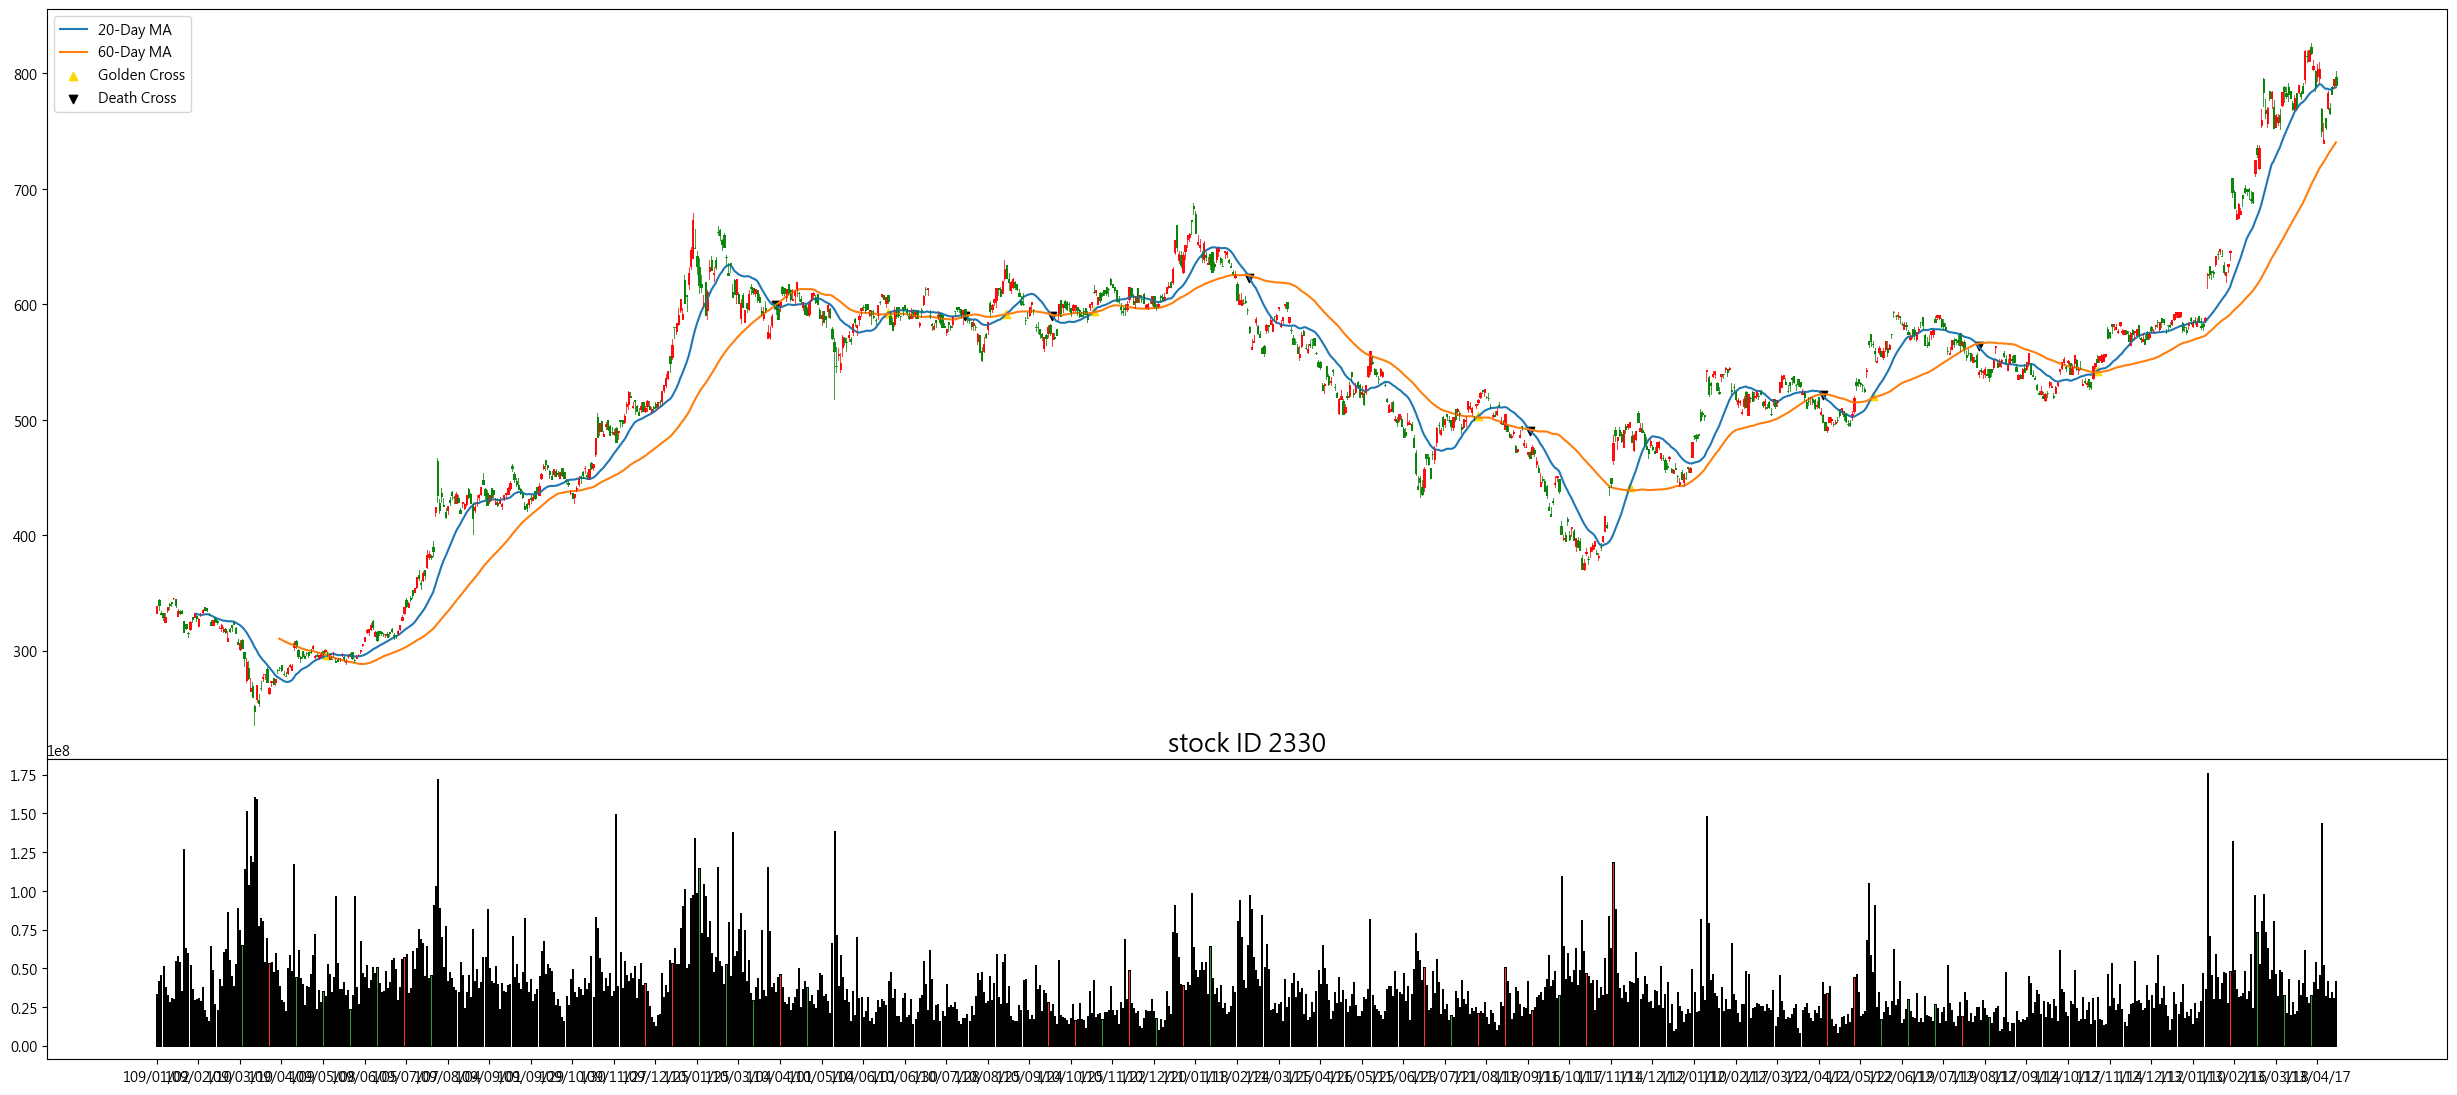

In [163]:
# step 3
plot_stock_data_with_moving_averages(engine, sql_name, sid, 60, 60)